# Airfoil optimization

In [1]:
from IPython.display import SVG, display


#stuff for neurofoil - pip install neuralfoil
from aerosandbox.geometry.airfoil.airfoil_families import get_kulfan_parameters, get_kulfan_coordinates
import aerosandbox as asb
import aerosandbox.numpy as np
import matplotlib.pyplot as plt
import aerosandbox.tools.pretty_plots as p


import matplotlib.pyplot as plt
import aerosandbox.tools.pretty_plots as p

import sys
import os

## Procedure 

Sources:
* http://servidor.demec.ufpr.br/CFD/bibliografia/aerodinamica/kulfan_2007.pdf
* https://www.tandfonline.com/doi/epdf/10.1080/19942060.2024.2445144
* https://github.com/peterdsharpe/NeuralFoil


Here the PINN is allready trained an provides the prediction. Therefore, the idea is, we shift the quantum opt. part to approximate a policy. 

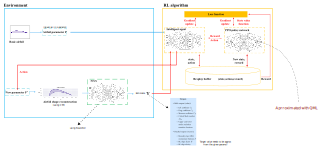

In [2]:
display(SVG(filename="optimprocedure.svg"))

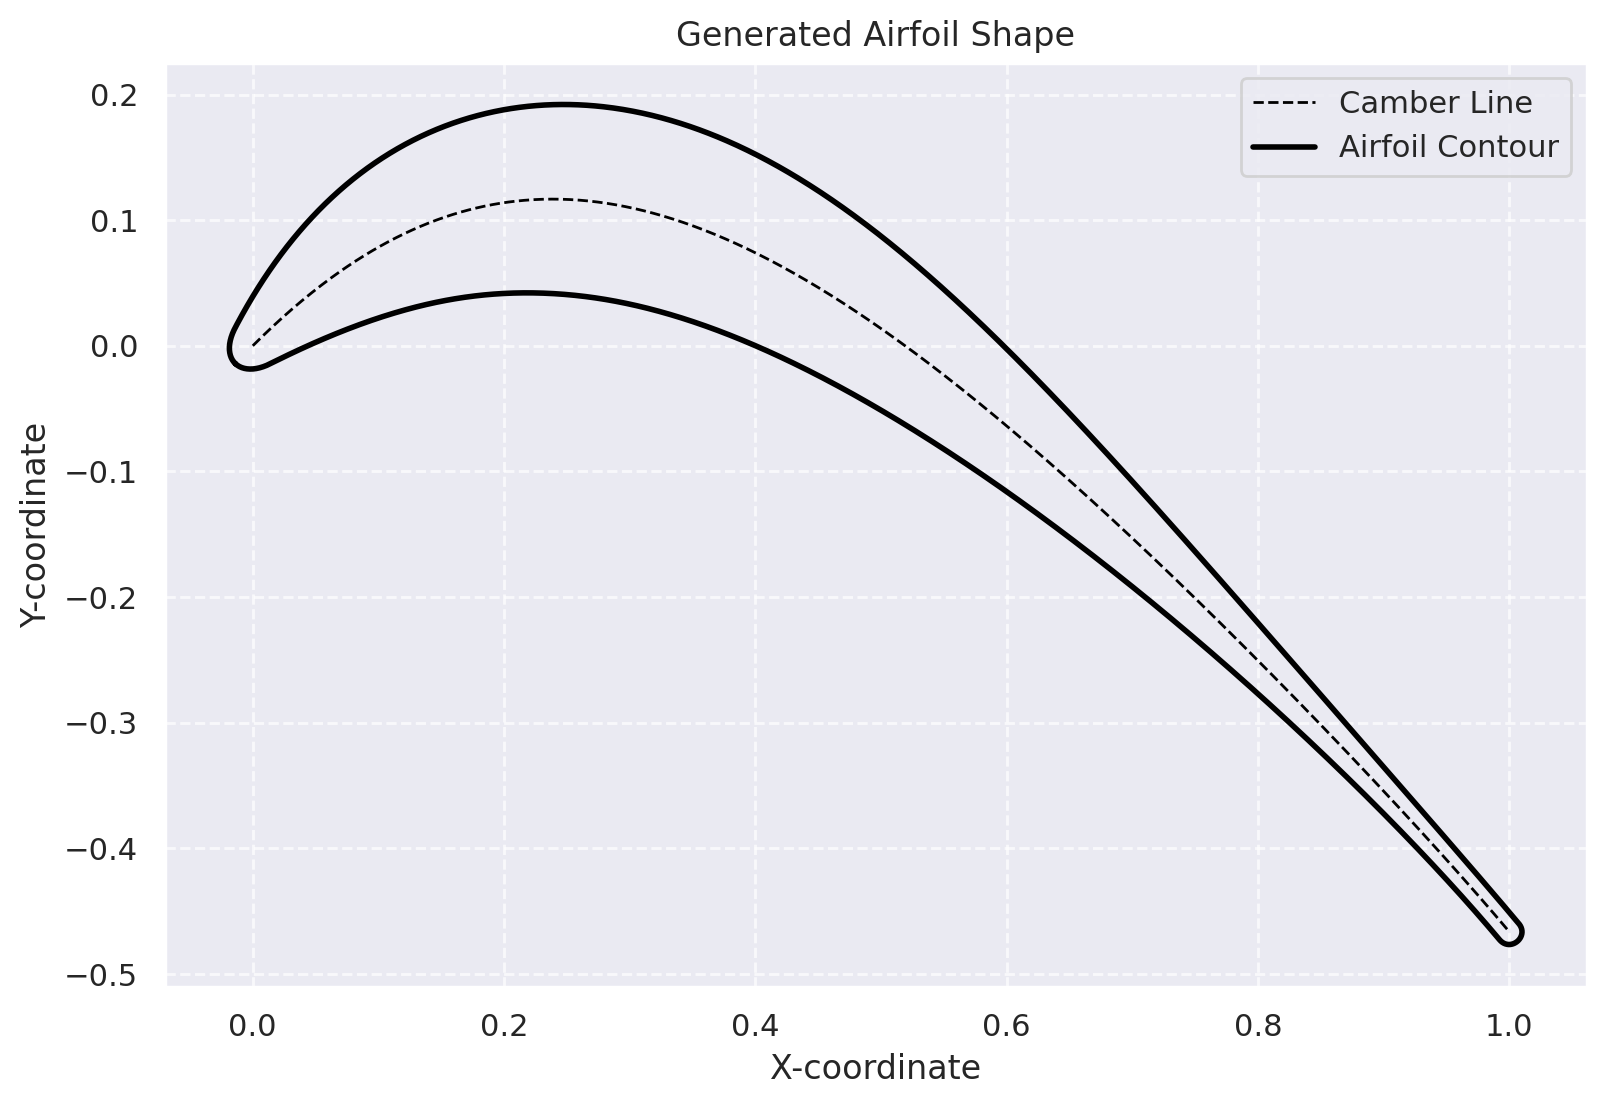

In [3]:
sys.path.append(os.path.abspath("../blade_design_tools"))
import create_airfoil
airfoil_top_points, airfoil_bottom_points, camber_curve_points = create_airfoil.generate_shape(config_filepath="../blade_design_tools/airfoil_config.yaml")

In [4]:
def get_neuralfoil_coordinates(airfoil_top_points, airfoil_bottom_points):
    """
        stacking is up for neurofoil
    """
    # Upper surface: reverse to go from TE to LE
    upper_te_to_le = np.flip(airfoil_top_points, axis=0)

    # Lower surface: LE to TE as is
    lower_le_to_te = airfoil_bottom_points

    # Check if LE points match (for sharp LE); avoid duplicating if so
    if np.allclose(upper_te_to_le[-1], lower_le_to_te[0]):
        coordinates = np.vstack((upper_te_to_le, lower_le_to_te[1:]))
    else:
        coordinates = np.vstack((upper_te_to_le, lower_le_to_te))
    return coordinates


# 7. Export for NeuralFoil
coordinates = get_neuralfoil_coordinates(airfoil_top_points, airfoil_bottom_points)
kulfan_params = get_kulfan_parameters(coordinates)
print("Kulfan parameters:", kulfan_params)

Kulfan parameters: {'lower_weights': array([-0.39463068,  0.5726026 ,  0.17745471,  0.6048875 ,  0.28333585,
        0.40413929,  0.45693178,  0.35682846]), 'upper_weights': array([0.67150686, 0.39899314, 1.0069387 , 0.45522572, 0.61792343,
       0.60628315, 0.35938593, 0.60352649]), 'TE_thickness': 0.013246050863871404, 'leading_edge_weight': 1.1031845273845675}


In [5]:
kulfan_airfoil = asb.KulfanAirfoil(name="State p'", **kulfan_params)

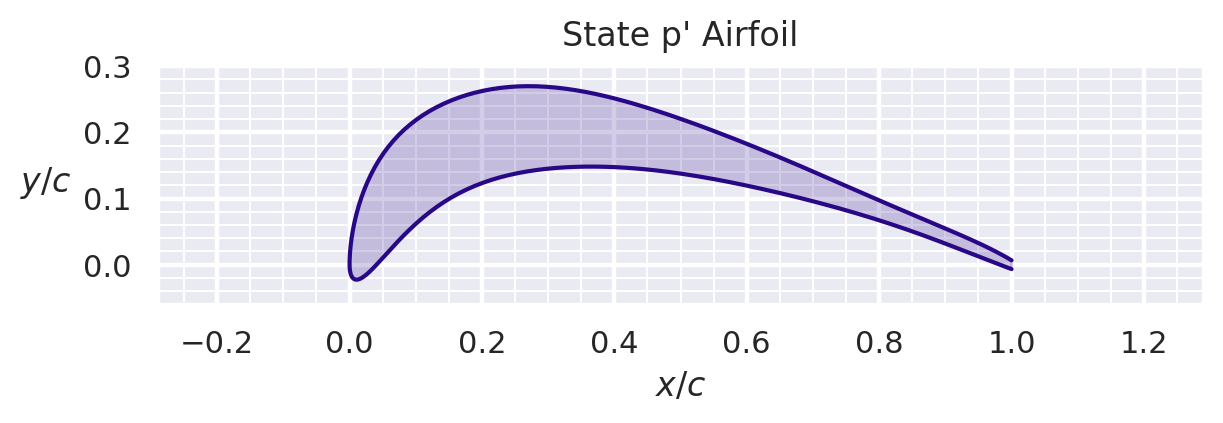

In [6]:
fig, ax = plt.subplots(figsize=(6, 2))
kulfan_airfoil.draw()

In [7]:
initial_guess_airfoil = kulfan_airfoil
opti = asb.Opti()

In [8]:
CL_multipoint_targets = np.array([0.8, 1.0, 1.2, 1.4, 1.5, 1.6])
CL_multipoint_weights = np.array([5, 6, 7, 8, 9, 10])

Re = 500e3 * (CL_multipoint_targets / 1.25) ** -0.5
mach = 0.7

In [9]:
optimized_airfoil = asb.KulfanAirfoil(
    name="Optimized",
    lower_weights=opti.variable(
        init_guess=initial_guess_airfoil.lower_weights,
        lower_bound=-0.5,
        upper_bound=0.25,
    ),
    upper_weights=opti.variable(
        init_guess=initial_guess_airfoil.upper_weights,
        lower_bound=-0.25,
        upper_bound=0.5,
    ),
    leading_edge_weight=opti.variable(
        init_guess=initial_guess_airfoil.leading_edge_weight,
        lower_bound=-1,
        upper_bound=1,
    ),
    TE_thickness=kulfan_params["TE_thickness"],
)

alpha = opti.variable(
    init_guess=45
)

In [10]:
# Why distinguish between aero and optimized airfoil
aero = optimized_airfoil.get_aero_from_neuralfoil(
    alpha=alpha,
    Re=Re,
    mach=mach,
)

# Test optimization frame work
### TODO's: 
- Implement real costfunction
- Shape constraints
- Implement the PPO, here we compare standard PPO vs. Quantum PPO

In [ ]:
#Actor -> creates the points: 
#Critic -> rejects them 

opti.subject_to([
    aero["analysis_confidence"] > 0.90,
    aero["CL"] == CL_multipoint_targets,
    np.diff(alpha) > 0,
    aero["CM"] >= -0.133,
    optimized_airfoil.local_thickness(x_over_c=0.33) >= 0.128,
    optimized_airfoil.local_thickness(x_over_c=0.90) >= 0.014,
    optimized_airfoil.TE_angle() >= 6.03, 
    optimized_airfoil.lower_weights[0] < -0.05,
    optimized_airfoil.upper_weights[0] > 0.05,
    optimized_airfoil.local_thickness() > 0
])

get_wiggliness = lambda af: sum([
    np.sum(np.diff(np.diff(array)) ** 2)
    for array in [af.lower_weights, af.upper_weights]
])

opti.subject_to(
    get_wiggliness(optimized_airfoil) < 2 * get_wiggliness(initial_guess_airfoil)
)


# Formulate an optimization goal based
opti.maximize(np.mean(aero["CL"] / aero["CD"]))

sol = opti.solve(
    max_iter = 0,
    behavior_on_failure="return_last",
    options={
       # "ipopt.mu_strategy": 'monotone',
       # "ipopt.start_with_resto": 'yes'
    }
)

optimized_airfoil_0 = sol(optimized_airfoil)

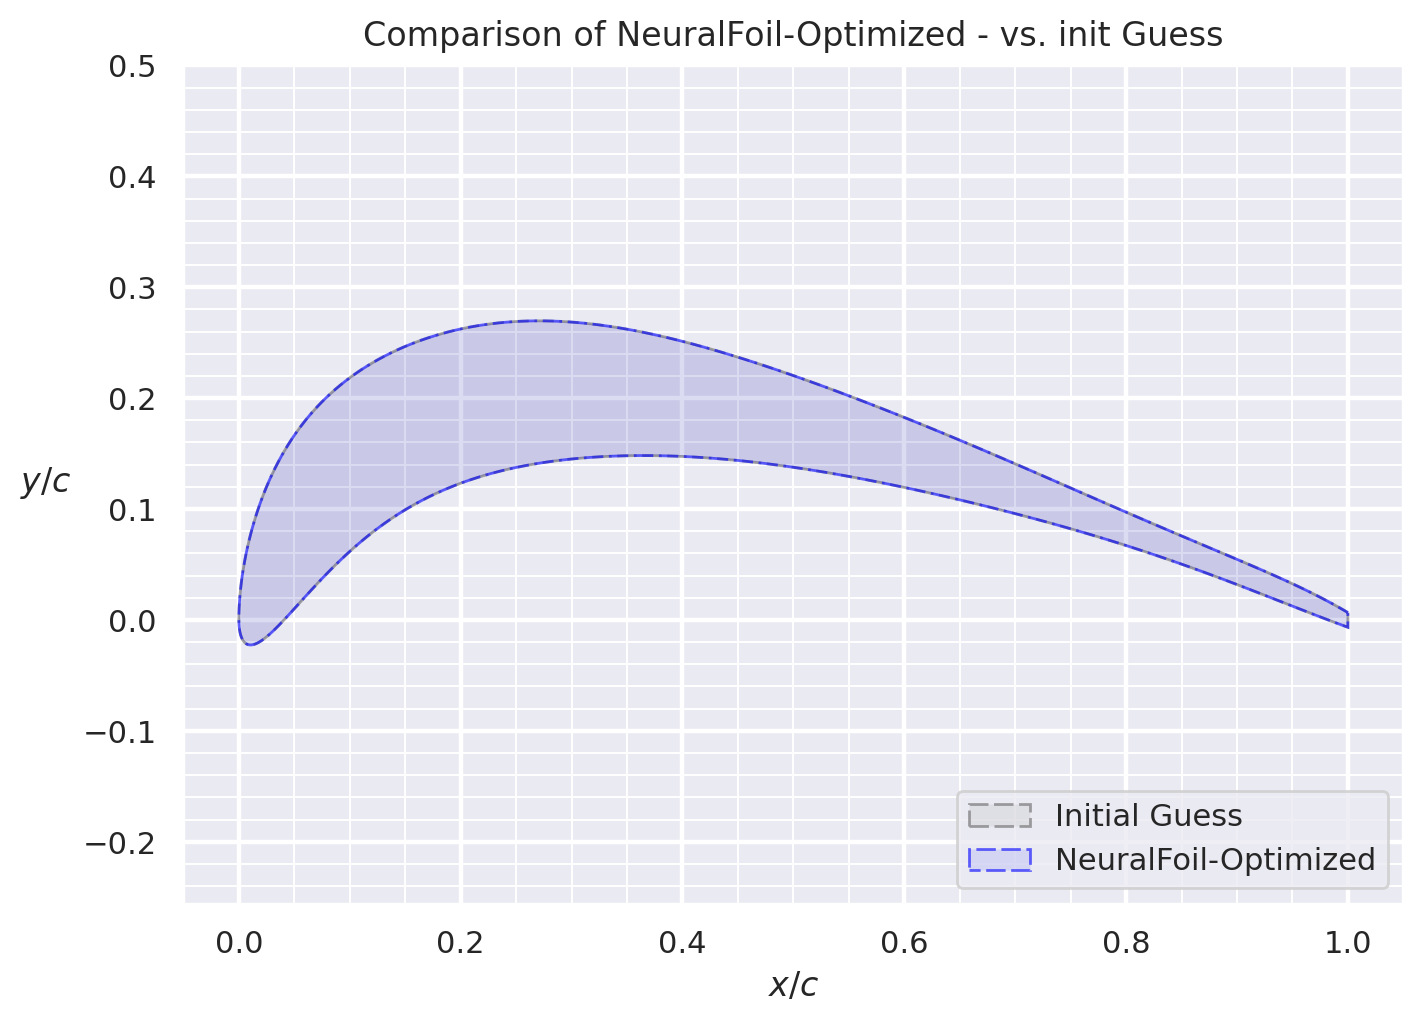

In [12]:
Re_plot = 500e3
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

airfoils_and_colors = {
    "Initial Guess"           : (initial_guess_airfoil, "dimgray"),
    "NeuralFoil-Optimized"    : (optimized_airfoil_0, "blue")}

for i, (name, (af, color)) in enumerate(airfoils_and_colors.items()):
    color = p.adjust_lightness(color, 1)
    ax.fill(
        af.x(), af.y(),
        facecolor=(*color, 0.09),
        edgecolor=(*color, 0.6),
        linewidth=1,
        label=name,
        linestyle=(3 * i, (7, 2)),
        zorder=4 if "NeuralFoil" in name else 3,
    )

ax.legend(fontsize=11, loc="lower right", ncol=len(airfoils_and_colors)//2)
ax.set_title("Airfoil Shapes")
ax.set_xlabel("$x/c$")
ax.set_ylabel("$y/c$")
ax.axis('equal')

p.show_plot("Comparison of NeuralFoil-Optimized - vs. init Guess", legend=False)

### Interface for NeuralFoil
This provides the values employed for guiding the optimization, here the method call for `get_aero_from_neuralfoil` yields the following values. Question: how to use this parameter to approximate our loss value sought? 

```python
return {
            "analysis_confidence": nf_aero["analysis_confidence"],
            "CL": CL,
            "CD": CD,
            "CM": CM,
            "Cpmin": Cpmin,
            "Top_Xtr": Top_Xtr,
            "Bot_Xtr": Bot_Xtr,
            "mach_crit": mach_crit,
            "mach_dd": mach_dd,
            "Cpmin_0": Cpmin_0,
            **{f"upper_bl_theta_{i}": nf_aero[f"upper_bl_theta_{i}"] for i in range(N)},
            **{f"upper_bl_H_{i}": nf_aero[f"upper_bl_H_{i}"] for i in range(N)},
            **{
                f"upper_bl_ue/vinf_{i}": nf_aero[f"upper_bl_ue/vinf_{i}"]
                for i in range(N)
            },
            **{f"lower_bl_theta_{i}": nf_aero[f"lower_bl_theta_{i}"] for i in range(N)},
            **{f"lower_bl_H_{i}": nf_aero[f"lower_bl_H_{i}"] for i in range(N)},
            **{
                f"lower_bl_ue/vinf_{i}": nf_aero[f"lower_bl_ue/vinf_{i}"]
                for i in range(N)
            },
        }
```

Hint the returns values such as CL are wrapped into Casadi type. Therefore we need to employ solve to evaluate the AD graph. 

In [13]:
# Having a look for aero at the start: -> needs to be validated agains the expeced ones
resolved_values_0 = sol(aero)
print(f"CD for the points: {resolved_values_0['CD']}")
print(f"CL for the points: {resolved_values_0['CL']}")

CD for the points: [1.27813715 1.2782529  1.2783494  1.27843238 1.27846993 1.2785053 ]
CL for the points: [0.74863172 0.74863172 0.74863172 0.74863172 0.74863172 0.74863172]


In [14]:
#Lets perfom for 500 iterations:

In [15]:
sol_2 = opti.solve(
    max_iter = 1000,
    behavior_on_failure="return_last",
    options={
       # "ipopt.mu_strategy": 'monotone',
       # "ipopt.start_with_resto": 'yes'
    }
)

optimized_airfoil_1000 = sol_2(optimized_airfoil)
resolved_values_1000 = sol_2(aero)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      108
Number of nonzeros in inequality constraint Jacobian.:     2021
Number of nonzeros in Lagrangian Hessian.............:      171

Total number of variables............................:       18
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        6
Total number of inequality constraints...............:      153
        inequality constraints with only lower bounds:      134
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       19

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -5.8561985e-01 9.00e-01 1.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

  86r-9.8795215e-01 9.00e-01 1.27e+01  -1.3 1.63e+00  -0.1 1.53e-01 1.30e-01f  1
  87r-9.8438426e-01 9.00e-01 2.79e+01  -1.3 1.12e+01    -  4.28e-02 1.87e-01f  1
  88r-9.8654937e-01 9.00e-01 2.53e+01  -1.3 3.89e+00  -0.5 2.81e-02 6.23e-02f  1
  89r-9.8746499e-01 9.00e-01 2.35e+01  -1.3 2.12e+00    -  3.86e-01 8.85e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90r-9.7679743e-01 9.00e-01 2.26e+01  -1.3 4.88e+00    -  3.34e-01 6.06e-01h  1
  91r-9.7888691e-01 9.00e-01 2.32e+01  -1.3 1.43e+02  -1.0 1.79e-03 7.46e-04f  2
  92r-9.8165741e-01 9.00e-01 2.32e+01  -1.3 2.34e+01    -  3.48e-02 6.35e-03f  1
  93r-9.8731306e-01 9.00e-01 2.51e+01  -1.3 1.68e+01    -  1.14e-01 7.04e-02f  1
  94r-9.8658006e-01 9.00e-01 2.38e+01  -1.3 2.52e+00  -0.6 2.23e-01 1.22e-01h  1
  95r-9.8802390e-01 9.00e-01 2.30e+01  -1.3 4.07e+00    -  7.34e-02 8.39e-02f  1
  96r-9.8823700e-01 9.00e-01 2.27e+01  -1.3 6.57e+00    -  2.73e-01 7.30e-02h  3
  97r-9.8726462e-01 9.00e-01

 183r-9.8436795e-01 9.00e-01 2.64e+01  -1.3 2.15e+00    -  3.16e-01 1.13e-01f  1
 184r-9.8733166e-01 9.00e-01 2.40e+01  -1.3 1.44e+01    -  1.91e-02 9.10e-02f  2
 185r-9.8021196e-01 9.00e-01 8.20e+00  -1.3 1.01e+00    -  9.34e-01 9.89e-01H  1
 186r-9.8912871e-01 9.00e-01 7.28e+01  -1.3 3.74e-01   0.7 2.20e-01 1.00e+00f  1
 187r-9.8873022e-01 9.00e-01 6.62e+01  -1.3 4.61e+00    -  1.67e-01 6.48e-02f  1
 188r-9.8804588e-01 9.00e-01 5.74e+01  -1.3 7.04e+00    -  1.64e-01 1.44e-01f  1
 189r-9.8886238e-01 9.00e-01 5.30e+01  -1.3 3.05e+00    -  1.32e-01 5.95e-02f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190r-9.8845016e-01 9.00e-01 6.58e+01  -1.3 2.82e+00    -  1.00e+00 9.29e-02h  4
 191r-9.8881640e-01 9.00e-01 5.85e+01  -1.3 3.80e+00    -  1.40e-01 1.17e-01h  3
 192r-9.8903715e-01 9.00e-01 4.94e+01  -1.3 1.48e+00    -  5.62e-01 8.04e-02h  3
 193r-9.8889515e-01 9.00e-01 4.47e+01  -1.3 1.86e+00    -  1.00e+00 1.35e-01h  3
 194r-9.8909420e-01 9.00e-01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280r-9.9150978e-01 9.00e-01 3.80e+00  -2.1 4.01e+01    -  6.79e-02 1.08e-02f  4
 281r-9.9163047e-01 9.00e-01 3.86e+00  -2.1 7.69e+01    -  1.34e-01 3.26e-02f  4
 282r-9.9156738e-01 9.00e-01 3.86e+00  -2.1 6.75e+01    -  4.95e-01 6.80e-02h  3
 283r-9.9162702e-01 9.00e-01 4.34e+00  -2.1 2.39e+01    -  2.63e-01 5.02e-02f  2
 284r-9.9169778e-01 9.00e-01 4.47e+00  -2.1 1.20e+01    -  8.48e-02 2.99e-02f  3
 285r-9.9209551e-01 9.00e-01 3.58e+00  -2.1 2.00e+01    -  1.00e+00 1.97e-01h  3
 286r-9.8437550e-01 9.00e-01 8.08e+00  -2.1 8.11e+00    -  1.99e-01 9.69e-01H  1
 287r-9.8643850e-01 9.00e-01 5.82e+00  -2.1 1.11e+00   0.4 2.94e-02 6.43e-02f  1
 288r-9.8756633e-01 9.00e-01 5.84e+00  -2.1 6.49e+01    -  4.89e-03 2.54e-03f  3
 289r-9.8846660e-01 9.00e-01 5.81e+00  -2.1 2.77e+01    -  4.55e-02 4.47e-03f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290r-9.8982993e-01 9.00e-01

 374r-9.9305046e-01 9.00e-01 5.15e+00  -2.0 2.28e-01   0.9 2.03e-01 1.00e+00h  1
 375r-9.9086055e-01 9.00e-01 4.04e+00  -2.0 3.37e+00    -  1.00e+00 6.64e-01f  1
 376r-9.9254327e-01 9.00e-01 1.41e+00  -2.0 2.79e+01    -  2.60e-02 3.27e-02f  1
 377r-9.8435343e-01 9.00e-01 1.25e+01  -2.0 1.61e+01    -  5.48e-02 1.66e-01f  1
 378r-9.8641385e-01 9.00e-01 1.08e+01  -2.0 1.13e+01   0.4 1.14e-02 7.85e-03f  1
 379r-9.9045017e-01 9.00e-01 1.31e+01  -2.0 2.67e+01    -  8.24e-02 8.46e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 380r-9.8665917e-01 9.00e-01 7.41e+00  -2.0 6.08e+00    -  9.79e-03 3.07e-01h  1
 381r-9.9182467e-01 9.00e-01 1.04e+01  -2.0 2.50e-01   0.8 2.79e-01 8.21e-01h  1
 382r-9.9269004e-01 9.00e-01 9.73e+00  -2.0 5.56e+00    -  3.38e-02 5.98e-02f  1
 383r-9.9064169e-01 9.00e-01 5.62e+00  -2.0 8.31e+00    -  1.93e-01 2.24e-01f  1
 384r-9.9148252e-01 9.00e-01 4.82e+00  -2.0 1.69e+01    -  1.71e-01 2.28e-02f  1
 385r-9.9312592e-01 9.00e-01

 471r-9.8998351e-01 9.00e-01 1.24e+01  -1.2 1.28e+01    -  6.87e-02 2.89e-02f  1
 472r-9.8856468e-01 9.00e-01 8.87e+00  -1.2 1.15e+00    -  2.76e-01 2.68e-01f  2
 473r-9.8990688e-01 9.00e-01 7.54e+00  -1.2 6.07e+00    -  1.38e-01 5.03e-02f  1
 474r-9.8966651e-01 9.00e-01 6.93e+00  -1.2 4.62e+00    -  6.04e-01 1.25e-01h  3
 475r-9.8789192e-01 9.00e-01 1.18e+01  -1.2 1.78e+00    -  3.32e-01 1.72e-01h  1
 476r-9.8911734e-01 9.00e-01 1.19e+01  -1.2 1.67e+00  -0.2 4.07e-02 7.41e-02f  1
 477r-9.8896372e-01 9.00e-01 2.56e+01  -1.2 1.02e+00   0.3 7.91e-01 1.75e-01h  3
 478r-9.8047657e-01 9.00e-01 1.52e+01  -1.2 6.34e-01  -0.2 9.13e-01 5.87e-01h  1
 479r-9.8406341e-01 9.00e-01 1.67e+01  -1.2 6.68e+00  -0.7 3.60e-02 1.89e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 480r-9.8495726e-01 9.00e-01 2.04e+01  -1.2 2.15e+01    -  7.28e-02 7.57e-02f  1
 481r-9.8886270e-01 9.00e-01 1.19e+01  -1.2 5.31e+00  -0.3 1.52e-03 3.12e-02f  1
 482r-9.8895371e-01 9.00e-01

 564r-9.9150603e-01 9.00e-01 7.12e+01  -1.2 9.72e-01   0.6 7.67e-01 9.88e-02h  3
 565r-9.9114806e-01 9.00e-01 6.04e+01  -1.2 1.47e+00    -  1.69e-01 2.45e-02h  5
 566r-9.8995707e-01 9.00e-01 2.77e+00  -1.2 1.74e-01   0.1 9.50e-01 1.00e+00h  1
 567r-9.8877793e-01 9.00e-01 5.64e+00  -1.8 2.07e+00    -  4.01e-01 1.25e-01f  1
 568r-9.8657983e-01 9.00e-01 5.14e+00  -1.8 2.28e+01    -  3.37e-02 5.93e-02f  1
 569r-9.9224221e-01 9.00e-01 8.98e+00  -1.8 1.03e+01    -  1.43e-02 1.02e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 570r-9.9051967e-01 9.00e-01 3.25e+00  -1.8 3.79e-01   0.5 7.73e-01 7.45e-01f  1
 571r-9.9048725e-01 9.00e-01 2.30e+00  -1.8 9.52e-01    -  1.76e-01 1.43e-01f  1
 572r-9.9064408e-01 9.00e-01 1.83e+00  -1.8 6.31e+00    -  1.83e-01 4.66e-02f  1
 573r-9.8690287e-01 9.00e-01 7.64e+00  -1.8 6.94e+00    -  2.70e-01 1.00e+00H  1
 574r-9.8855569e-01 9.00e-01 1.33e+01  -1.8 1.22e+00   0.1 1.55e-01 2.02e-01f  1
 575r-9.8878954e-01 9.00e-01

 659r-9.8816623e-01 9.00e-01 1.98e+01  -1.8 3.85e+00    -  9.97e-02 5.41e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 660r-9.8823060e-01 9.00e-01 1.96e+01  -1.8 4.91e+00    -  3.25e-01 1.39e-02h  5
 661r-9.8840079e-01 9.00e-01 1.87e+01  -1.8 2.19e+00    -  2.61e-01 4.72e-02h  5
 662r-9.8839162e-01 9.00e-01 1.86e+01  -1.8 6.84e+00    -  1.90e-01 8.21e-03h  5
 663r-9.8840858e-01 9.00e-01 1.86e+01  -1.8 3.04e+00    -  2.02e-01 2.48e-03h  7
 664r-9.8841580e-01 9.00e-01 1.85e+01  -1.8 4.22e+00    -  1.00e+00 1.21e-03h  9
 665r-9.8841718e-01 9.00e-01 1.85e+01  -1.8 3.37e+00    -  3.77e-01 3.05e-04h 12
 666r-9.8841793e-01 9.00e-01 1.85e+01  -1.8 4.93e+00    -  1.00e+00 1.35e-04h 13
 667r-9.8868501e-01 9.00e-01 1.64e+01  -1.8 3.52e+00    -  3.32e-01 1.36e-01h  3
 668r-9.8887399e-01 9.00e-01 1.62e+01  -1.8 6.47e+00    -  3.24e-01 7.20e-02h  1
 669r-9.8883361e-01 9.00e-01 1.66e+01  -1.8 5.12e+00    -  9.93e-02 3.31e-02f  1
iter    objective    inf_pr 

 752r-9.9293104e-01 9.00e-01 3.32e+00  -1.9 5.52e-01    -  1.00e+00 1.00e+00h  1
 753r-9.9024331e-01 9.00e-01 7.40e+00  -1.9 1.49e+01    -  4.43e-02 8.36e-02f  1
 754r-9.9149080e-01 9.00e-01 8.06e+00  -1.9 1.33e+01    -  4.57e-02 2.34e-02f  1
 755r-9.9140949e-01 9.00e-01 7.97e+00  -1.9 5.52e+00    -  2.48e-01 1.13e-01f  1
 756r-9.9171403e-01 9.00e-01 7.84e+00  -1.9 1.01e+01    -  3.78e-02 3.34e-02h  1
 757r-9.9173934e-01 9.00e-01 7.75e+00  -1.9 8.08e+00    -  1.78e-01 3.39e-02f  4
 758r-9.9177376e-01 9.00e-01 7.30e+00  -1.9 3.84e+00    -  4.06e-01 1.08e-01h  1
 759r-9.9146202e-01 9.00e-01 7.36e+00  -1.9 5.34e+00    -  2.11e-01 1.51e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 760r-9.9136093e-01 9.00e-01 8.61e+00  -1.9 7.19e+00    -  1.99e-01 5.96e-02f  1
 761r-9.9113314e-01 9.00e-01 9.04e+00  -1.9 7.60e+00    -  3.14e-02 1.13e-01f  2
 762r-9.9089562e-01 9.00e-01 9.53e+00  -1.9 8.02e+00    -  2.76e-01 1.12e-01h  1
 763r-9.9131838e-01 9.00e-01

 846r-9.8817436e-01 9.00e-01 2.22e+01  -1.9 5.52e+00    -  4.96e-02 5.29e-02h  4
 847r-9.8836579e-01 9.00e-01 2.22e+01  -1.9 4.09e+01    -  4.44e-02 1.45e-03f  2
 848r-9.8852932e-01 9.00e-01 2.23e+01  -1.9 6.10e+00    -  4.42e-01 2.05e-02f  1
 849r-9.9005175e-01 9.00e-01 1.23e+01  -1.9 5.11e+00    -  5.03e-01 4.68e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 850r-9.9022441e-01 9.00e-01 1.30e+01  -1.9 1.03e+01    -  1.74e-01 1.71e-02f  1
 851r-9.9005341e-01 9.00e-01 1.09e+01  -1.9 9.22e-01    -  5.56e-02 2.72e-01h  1
 852r-9.9039406e-01 9.00e-01 1.11e+01  -1.9 1.07e+01    -  3.54e-02 8.88e-03f  1
 853r-9.9054710e-01 9.00e-01 1.12e+01  -1.9 3.38e+01    -  1.82e-01 2.77e-02f  2
 854r-9.8919630e-01 9.00e-01 8.36e+00  -1.9 3.65e+00    -  2.13e-01 5.00e-01h  2
 855r-9.9015071e-01 9.00e-01 8.58e+00  -1.9 3.04e+01    -  3.09e-02 5.64e-03f  1
 856r-9.9056491e-01 9.00e-01 1.25e+01  -1.9 7.44e+00    -  2.23e-01 6.62e-02f  3
 857r-9.9075220e-01 9.00e-01

 941r-9.9174282e-01 9.00e-01 5.80e+01  -2.8 3.86e-01   2.2 8.35e-01 5.75e-01h  1
 942r-9.9379631e-01 9.00e-01 7.50e+01  -2.8 1.45e+02    -  4.40e-02 1.03e-01f  1
 943r-9.9337183e-01 9.00e-01 1.60e+02  -2.8 5.33e+00    -  8.89e-01 2.50e-01h  3
 944r-9.9283326e-01 9.00e-01 1.18e+02  -2.8 2.77e+00    -  1.94e-01 2.50e-01h  3
 945r-9.9280192e-01 9.00e-01 1.24e+02  -2.8 1.71e+01    -  3.33e-01 1.56e-02h  7
 946r-9.9188166e-01 9.00e-01 5.68e+01  -2.8 4.25e+00    -  2.15e-01 5.00e-01h  2
 947r-9.9206683e-01 9.00e-01 5.75e+01  -2.8 2.15e+03    -  8.90e-03 1.62e-03f  1
 948r-9.9127093e-01 9.00e-01 3.34e+01  -2.8 4.67e+00    -  1.00e+00 5.00e-01h  2
 949r-9.9124346e-01 9.00e-01 2.82e+01  -2.8 5.07e-02   1.8 1.00e+00 6.25e-02h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 950r-9.9123067e-01 9.00e-01 3.44e+01  -2.8 5.52e-02   1.3 8.50e-01 3.12e-02h  6
 951r-9.9122353e-01 9.00e-01 3.01e+01  -2.8 6.34e-02   0.8 1.00e+00 1.56e-02h  7
 952r-9.9122237e-01 9.00e-01

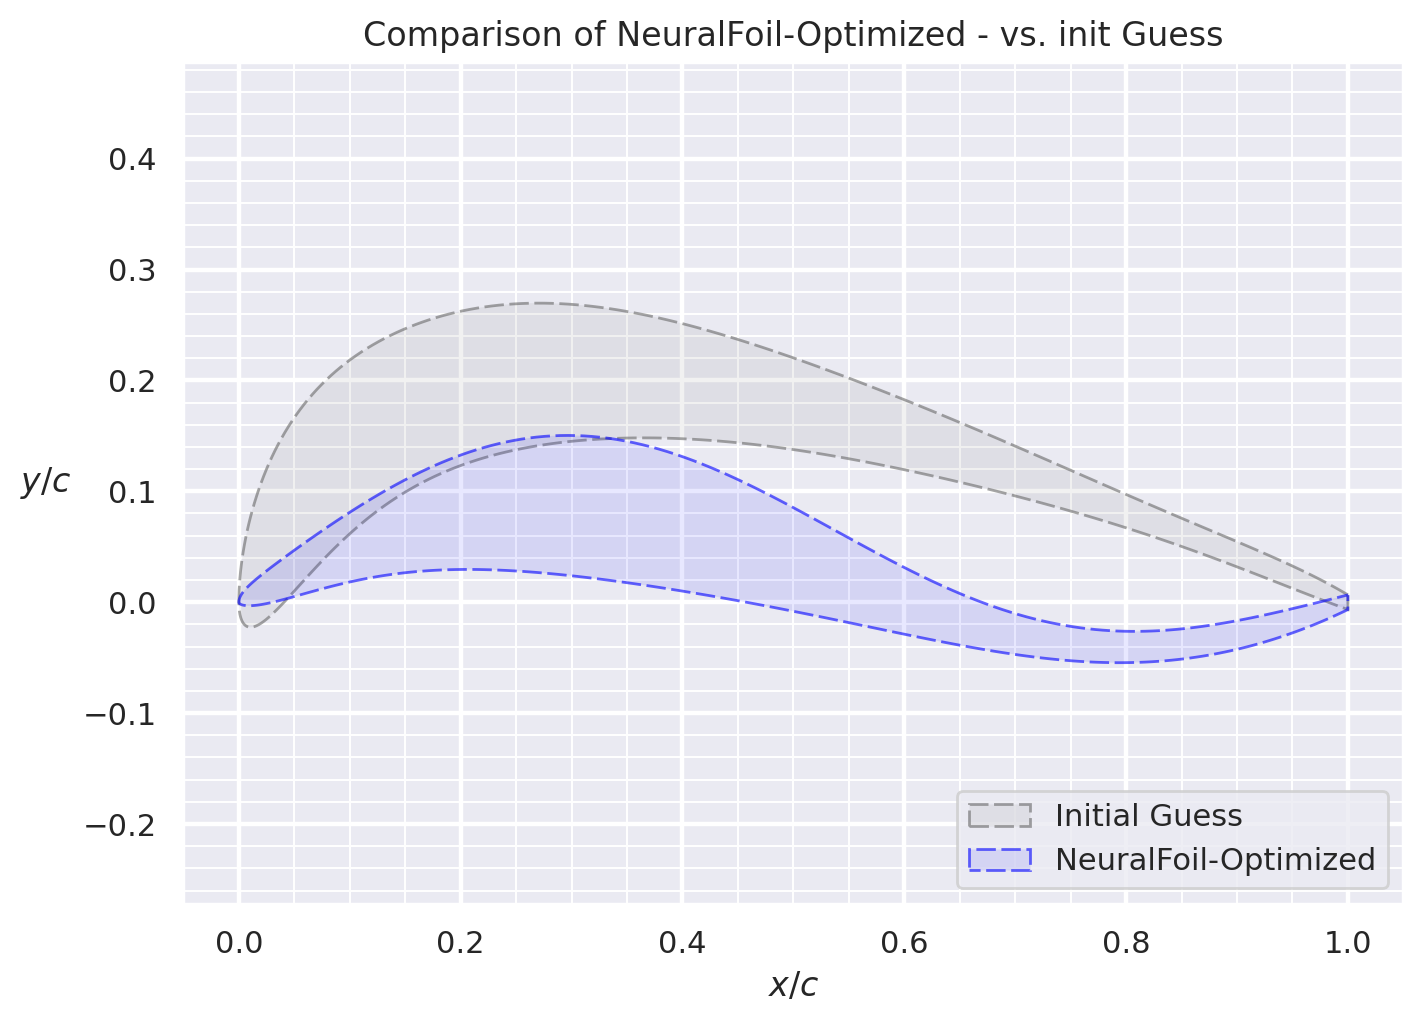

In [16]:
Re_plot = 500e3
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

airfoils_and_colors = {
    "Initial Guess"           : (initial_guess_airfoil, "dimgray"),
    "NeuralFoil-Optimized"    : (optimized_airfoil_1000, "blue")}

for i, (name, (af, color)) in enumerate(airfoils_and_colors.items()):
    color = p.adjust_lightness(color, 1)
    ax.fill(
        af.x(), af.y(),
        facecolor=(*color, 0.09),
        edgecolor=(*color, 0.6),
        linewidth=1,
        label=name,
        linestyle=(3 * i, (7, 2)),
        zorder=4 if "NeuralFoil" in name else 3,
    )

ax.legend(fontsize=11, loc="lower right", ncol=len(airfoils_and_colors)//2)
ax.set_title("Airfoil Shapes")
ax.set_xlabel("$x/c$")
ax.set_ylabel("$y/c$")
ax.axis('equal')

p.show_plot("Comparison of NeuralFoil-Optimized - vs. init Guess", legend=False)

In [17]:
print(f"CD for the points: {resolved_values_500['CD']}")
print(f"CL for the points: {resolved_values_500['CL']}")

NameError: name 'resolved_values_500' is not defined